In [58]:
import acquire

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
import seaborn as sns


# decision tree evaluated on imbalanced dataset with SMOTE oversampling
#from numpy import mean
#from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def train_validate_test_split(df, target):
    train_validate, test = train_test_split(df, test_size=0.2,  
                                            stratify=df[target], random_state = 123)
    
    
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       stratify=train_validate[target], random_state = 123)
    return train, validate, test

In [2]:
df = acquire.get_brazil_data()
df.head()

,Patient.Code,RCBP.Name,Gender,Date.of.Birth,Age,Raca.Color,Nationality,Naturality.State,Naturality,Degree.of.Education,...,Laterality,Statement,TNM,Status.Vital,Type.of.Death,Date.of.Death,Date.of.Last.Contact,Date.of.Diagnostic,Distant.metastasis,year
0,672054.0,RCBP CAMPINAS-UNICAMP,MASCULINO,1975-03-16,30.0,BRANCO,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-10-07,2005-10-07,2005-10-07,NaN,2005.0
1,673213.0,RCBP CAMPINAS-UNICAMP,FEMININO,1950-05-24,53.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,MORTO,NaN,2007-01-30,2007-01-30,2003-07-18,NaN,2003.0
2,673396.0,RCBP CAMPINAS-UNICAMP,FEMININO,1951-09-02,51.0,PARDA,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-07-03,2005-07-03,2003-05-16,NaN,2003.0
3,673425.0,RCBP CAMPINAS-UNICAMP,FEMININO,1929-11-21,73.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,VIVO,NaN,NaN,2010-07-28,2003-04-01,NaN,2003.0
4,673745.0,RCBP CAMPINAS-UNICAMP,MASCULINO,1934-07-03,71.0,BRANCO,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-10-21,2005-10-21,2005-10-21,NaN,2005.0


In [3]:
df.shape

(1778176, 38)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778176 entries, 0 to 1778175
Data columns (total 38 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Patient.Code                     float64
 1   RCBP.Name                        object 
 2   Gender                           object 
 3   Date.of.Birth                    object 
 4   Age                              float64
 5   Raca.Color                       object 
 6   Nationality                      object 
 7   Naturality.State                 object 
 8   Naturality                       object 
 9   Degree.of.Education              object 
 10  State.Civil                      object 
 11  Code.Profession                  float64
 12  Name.Occupation                  object 
 13  Status.Address                   object 
 14  City.Address                     object 
 15  Description.of.Topography        object 
 16  Topography.Code                  object 
 17  Morpholo

In [7]:
df['Status.Vital'].value_counts()

MORTO    123862
VIVO      85896
Name: Status.Vital, dtype: int64

In [8]:
df['Type.of.Death'].value_counts()

C�NCER        375903
N�O C�NCER     23376
Name: Type.of.Death, dtype: int64

In [11]:
df.Nationality.value_counts()

BRASIL           811183
PORTUGAL            749
ITALIA              451
JAPAO               448
ESPANHA             266
                  ...  
BAREIN                1
AFEGANISTAO           1
SUDAO                 1
ILHAS NORFOLK         1
ANTIGUA               1
Name: Nationality, Length: 113, dtype: int64

In [14]:
df.isna().sum()

Patient.Code                         74429
RCBP.Name                                0
Gender                                   0
Date.of.Birth                       768445
Age                                  79972
Raca.Color                          785048
Nationality                         962996
Naturality.State                   1326620
Naturality                         1591764
Degree.of.Education                1372348
State.Civil                        1179041
Code.Profession                     140150
Name.Occupation                     140150
Status.Address                       64197
City.Address                         63842
Description.of.Topography                0
Topography.Code                          0
Morphology.Description                   0
Code.of.Morphology                       0
Description.of.Disease                   0
Illness.Code                             0
Child.Illness.Description          1079470
Child.Illness.Code                 1079470
Youth.Adult

In [15]:
df['Type.of.Death']

0          C�NCER
1             NaN
2          C�NCER
3             NaN
4          C�NCER
            ...  
1778171       NaN
1778172       NaN
1778173       NaN
1778174       NaN
1778175       NaN
Name: Type.of.Death, Length: 1778176, dtype: object

In [19]:
df['Status.Vital'].isna().sum()

1568418

In [17]:
# Explain a lot of the data is missing, for cancer and death (thats why I have to drop about 80% of the data)

## I'll use this for just looking for cancer or no cancer 

In [78]:
df_cancer = df.copy()

In [79]:
df_cancer = df_cancer[df_cancer['Type.of.Death'].notna()]

In [80]:
df_cancer.shape

(399279, 38)

In [81]:
df_cancer.head()

,Patient.Code,RCBP.Name,Gender,Date.of.Birth,Age,Raca.Color,Nationality,Naturality.State,Naturality,Degree.of.Education,...,Laterality,Statement,TNM,Status.Vital,Type.of.Death,Date.of.Death,Date.of.Last.Contact,Date.of.Diagnostic,Distant.metastasis,year
0,672054.0,RCBP CAMPINAS-UNICAMP,MASCULINO,1975-03-16,30.0,BRANCO,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-10-07,2005-10-07,2005-10-07,NaN,2005.0
2,673396.0,RCBP CAMPINAS-UNICAMP,FEMININO,1951-09-02,51.0,PARDA,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-07-03,2005-07-03,2003-05-16,NaN,2003.0
4,673745.0,RCBP CAMPINAS-UNICAMP,MASCULINO,1934-07-03,71.0,BRANCO,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-10-21,2005-10-21,2005-10-21,NaN,2005.0
5,676350.0,RCBP CAMPINAS-UNICAMP,MASCULINO,1933-11-18,71.0,BRANCO,BRASIL,S�O PAULO,NaN,SUPERIOR COMPLETO,...,NaN,NaN,NaN,MORTO,C�NCER,2005-11-06,2005-11-06,2005-11-06,NaN,2005.0
6,679877.0,RCBP CAMPINAS-UNICAMP,FEMININO,1947-11-30,57.0,PARDA,BRASIL,ALAGOAS,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-05-15,2005-05-15,2005-05-15,NaN,2005.0


In [82]:
df_cancer['Type.of.Death'].value_counts()

C�NCER        375903
N�O C�NCER     23376
Name: Type.of.Death, dtype: int64

In [83]:
df_cancer = df_cancer.drop(columns=['Child.Illness.Description', 'Child.Illness.Code', 'Description.of.Disease',
                'Illness.Code', 'Youth.Adult.Illness.Description', 'Code.of.Disease.Adult.Young.',
                'Patient.Code' , 'RCBP.Name', 'Date.of.Birth',
                'TNM', 'Extension', 'Statement', 'Topography.Code', 'Morphology.Description',
                'Code.of.Morphology', 'Description.of.Disease', 'Illness.Code', 'Description.of.Topography',
                'Date.of.Last.Contact', 'Date.of.Diagnostic', 'Distant.metastasis', 'Code.Profession',
                'Name.Occupation','Laterality', 'Date.of.Death','Naturality','Naturality.State', 'Status.Vital'])

In [84]:
df_cancer = df_cancer[df_cancer['Age'] <= 120]

In [85]:
df_cancer['Degree.of.Education'].value_counts()

FUNDAMENTAL I (1� A 4� S�RIE)     66856
FUNDAMENTAL II (5� A 8� S�RIE)    49791
M�DIO (ANTIGO SEGUNDO GRAU)       43592
SUPERIOR COMPLETO                 29774
SEM ESCOLARIDADE                  26144
SUPERIOR INCOMPLETO                1800
Name: Degree.of.Education, dtype: int64

In [86]:
df_cancer['State.Civil'].value_counts()

CASADO                    151033
SOLTEIRO                   68053
VI�VO                      63383
SEPARADO JUDICIALMENTE     21271
UNI�O CONSENSUAL            6444
Name: State.Civil, dtype: int64

In [87]:
df_cancer = df_cancer[df_cancer['Diagnostic.means'].notna()]
df_cancer = df_cancer[df_cancer['Indicator.of.Rare.Case'].notna()]
df_cancer = df_cancer[df_cancer['Degree.of.Education'].notna()]


df_cancer['Raca.Color'] = df_cancer['Raca.Color'].fillna('BRANCO')
df_cancer['Nationality'] = df_cancer['Nationality'].fillna('BRASIL')
df_cancer['State.Civil'] = df_cancer['State.Civil'].fillna('CASADO')

In [88]:
df_cancer['Degree.of.Education'] = df_cancer['Degree.of.Education'].replace(regex={r'^FUNDAMENTAL I .1. A 4. S.RIE.$': 'Fundamental I',
                  r'^FUNDAMENTAL II .5. A 8. S.RIE.$': 'Fundamental II',
                 r'^M.DIO .ANTIGO SEGUNDO GRAU.$': 'Former Second Degree',
                 'SEM ESCOLARIDADE': 'Without Education', 'SUPERIOR COMPLETO' : 'Graduated',
                 'SUPERIOR INCOMPLETO' : 'Incomplete High'})



In [89]:
df_cancer['Type.of.Death'] = df_cancer['Type.of.Death'].replace(regex={r'^C.NCER$': 'Cancer', r'^N.O C.NCER$': 'No Cancer'})

df_cancer['Gender'] = df_cancer['Gender'].replace(regex={r'^MASCULINO$': 'Male', r'^FEMININO$': 'Female', r'^IGNORADO$' : 'Ignored'})



In [90]:
df_cancer.rename(columns={'State.Civil' : 'Legal_Status',
                  'Degree.of.Education' : 'Education',
                   'Type.of.Death' : 'Type_of_Death', 'Status.Address' : 'Status_Address',
                   'City.Address' : 'City_Address', 'Diagnostic.means' : 'Diagnostic_means',
                  'Raca.Color' : 'Race_Color', 'Indicator.of.Rare.Case' : 'Rare_Case'}, inplace=True)

In [91]:
dummy_df = pd.get_dummies(df_cancer[['Gender', 'Type_of_Death', 'Education', 'Race_Color', 'Legal_Status']],
                             dummy_na = False, drop_first = [True])

df_cancer = pd.concat([df_cancer, dummy_df], axis = 1)

In [92]:
df_cancer.isna().sum()

Gender                                 0
Age                                    0
Race_Color                             0
Nationality                            0
Education                              0
Legal_Status                           0
Status_Address                         0
City_Address                           0
Rare_Case                              0
Diagnostic_means                       0
Type_of_Death                          0
year                                   0
Gender_Ignored                         0
Gender_Male                            0
Type_of_Death_No Cancer                0
Education_Fundamental I                0
Education_Fundamental II               0
Education_Graduated                    0
Education_Incomplete High              0
Education_Without Education            0
Race_Color_BRANCO                      0
Race_Color_IND�GENA                    0
Race_Color_PARDA                       0
Race_Color_PRETA                       0
Legal_Status_SEP

In [93]:
df_cancer.rename(columns={'Type_of_Death_No Cancer': 'has_No_Cancer'}, inplace=True)

In [94]:
train, validate, test = train_validate_test_split(df_cancer, 'Type_of_Death')

In [95]:
train.head()

,Gender,Age,Race_Color,Nationality,Education,Legal_Status,Status_Address,City_Address,Rare_Case,Diagnostic_means,...,Education_Incomplete High,Education_Without Education,Race_Color_BRANCO,Race_Color_IND�GENA,Race_Color_PARDA,Race_Color_PRETA,Legal_Status_SEPARADO JUDICIALMENTE,Legal_Status_SOLTEIRO,Legal_Status_UNI�O CONSENSUAL,Legal_Status_VI�VO
1566782,Male,67.0,BRANCO,BRASIL,Fundamental II,CASADO,S�O PAULO,VIRADOURO,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,0,1,0,0,0,0,0,0,0
1755729,Male,62.0,PARDA,BRASIL,Former Second Degree,CASADO,RONDONIA,S�O FRANCISCO DO GUAPOR�,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,0,0,0,1,0,0,0,0,0
495077,Male,87.0,BRANCO,BRASIL,Fundamental II,CASADO,MATO GROSSO,CUIAB�,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,0,1,0,0,0,0,0,0,0
1621704,Male,87.0,PARDA,BRASIL,Fundamental I,CASADO,CEAR�,FORTALEZA,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,0,0,0,1,0,0,0,0,0
1507590,Female,87.0,BRANCO,BRASIL,Without Education,VI�VO,MATO GROSSO,JUSCIMEIRA,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,1,1,0,0,0,0,0,0,1


In [45]:
Counter(train.Type_of_Death)

Counter({'Cancer': 114385, 'No Cancer': 6328})

In [27]:
# define pipeline
#over = SMOTE(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)
# transform the dataset
#train = pipeline.fit_resample(train)


In [47]:
pd.crosstab(train['Type_of_Death'], train['has_No_Cancer'])

has_No_Cancer,0,1
Type_of_Death,,
Cancer,114385,0
No Cancer,0,6328


# Legal Status their cancer rates

<AxesSubplot:title={'center':'Legal Status and their cancer rates'}, xlabel='Legal_Status', ylabel='has_No_Cancer'>

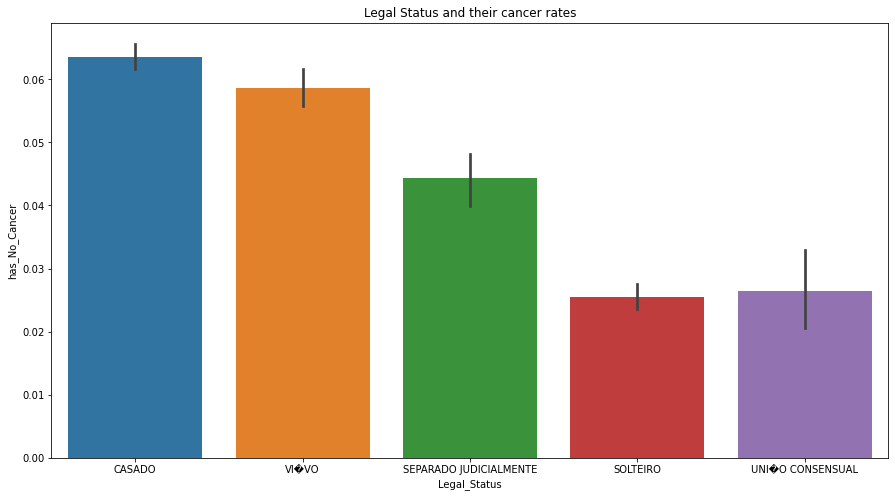

In [49]:
plt.figure(figsize=(15,8))
plt.title('Legal Status and their cancer rates')
sns.barplot(x = 'Legal_Status', y = 'has_No_Cancer', data = train)

# Race/Color and those with no cancer

<AxesSubplot:title={'center':'Race/Color and their cancer rates'}, xlabel='Race_Color', ylabel='has_No_Cancer'>

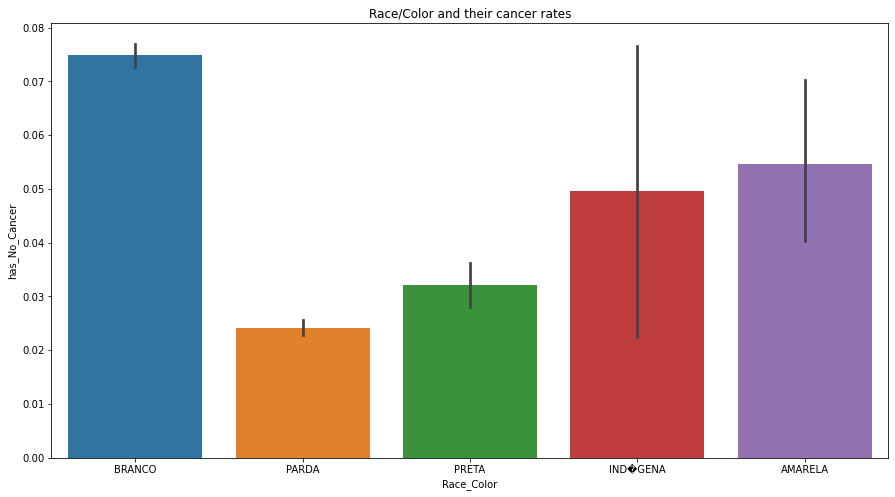

In [57]:
plt.figure(figsize=(15,8))
plt.title('Race/Color and their cancer rates')
sns.barplot(x = 'Race_Color', y = 'has_No_Cancer', data = train)

<AxesSubplot:title={'center':'Branco and their cancer rates'}, xlabel='Race_Color_BRANCO', ylabel='has_No_Cancer'>

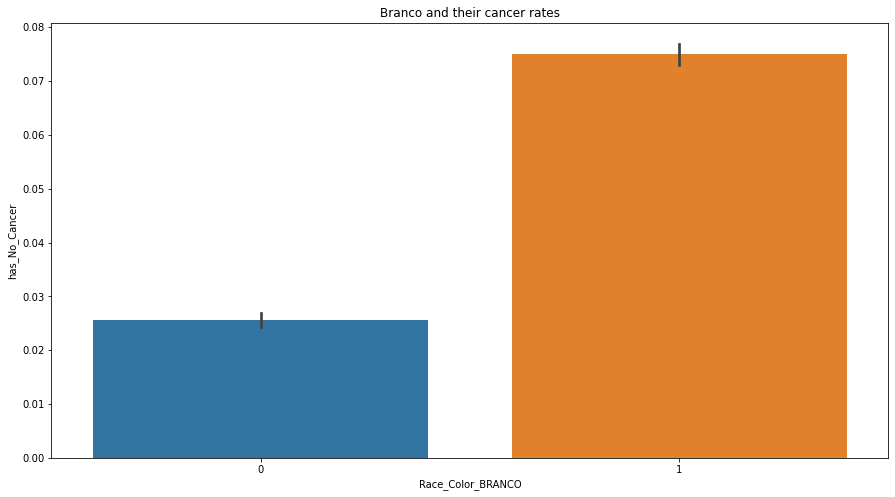

In [96]:
plt.figure(figsize=(15,8))
plt.title('Branco and their cancer rates')
sns.barplot(x = 'Race_Color_BRANCO', y = 'has_No_Cancer', data = train)

In [97]:
observed = pd.crosstab(train['Race_Color_BRANCO'], train.has_No_Cancer)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.12f}')

Observed
has_No_Cancer          0     1
Race_Color_BRANCO             
0                  53769  1417
1                  60616  4911
--------------------------------------
---
Expected
[[52293.04722772  2892.95277228]
 [62091.95277228  3435.04722772]]
--------------------------------------
---

chi^2 = 1462.9450
p     = 0.000000000000


# Which education bracket has mostly no cancer patients and is signifcant?

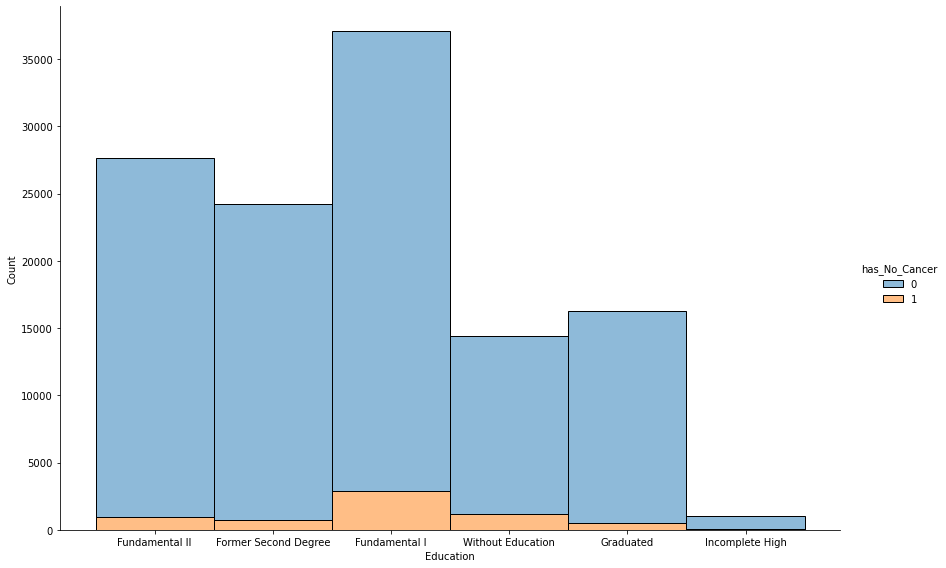

In [53]:
sns.displot(x = 'Education', data = train, hue = 'has_No_Cancer', alpha = 0.5, multiple = 'stack',
            height=8, aspect=12/8)

<AxesSubplot:title={'center':'Education Fundamental I and their cancer rates'}, xlabel='Education_Fundamental I', ylabel='has_No_Cancer'>

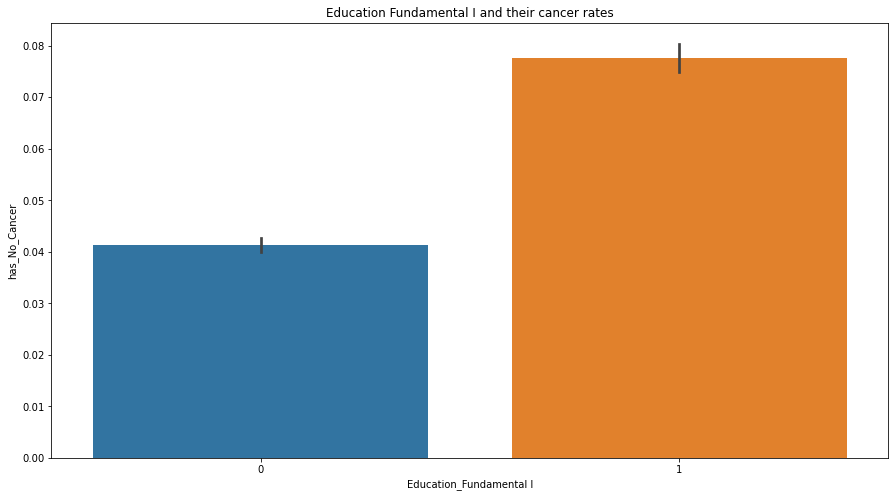

In [98]:
plt.figure(figsize=(15,8))
plt.title('Education Fundamental I and their cancer rates')
sns.barplot(x = 'Education_Fundamental I', y = 'has_No_Cancer', data = train)

In [99]:
observed = pd.crosstab(train['Education_Fundamental I'], train.has_No_Cancer)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.12f}')

Observed
has_No_Cancer                0     1
Education_Fundamental I             
0                        80196  3452
1                        34189  2876
--------------------------------------
---
Expected
[[79263.01624514  4384.98375486]
 [35121.98375486  1943.01624514]]
--------------------------------------
---

chi^2 = 681.5372
p     = 0.000000000000


# Is being male a reason for no cancer?

<AxesSubplot:title={'center':'Male or not and their cancer rates'}, xlabel='Gender_Male', ylabel='has_No_Cancer'>

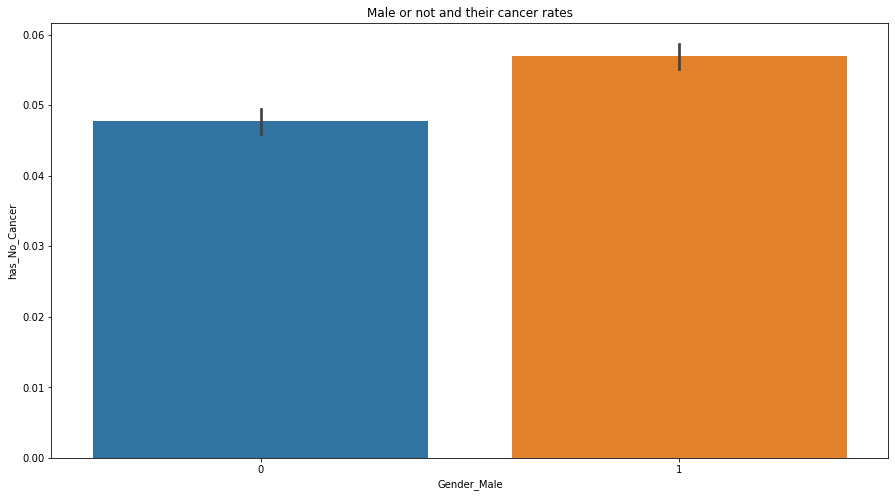

In [56]:
plt.figure(figsize=(15,8))
plt.title('Male or not and their cancer rates')
sns.barplot(x = 'Gender_Male', y = 'has_No_Cancer', data = train)

In [62]:
observed = pd.crosstab(train['Gender_Male'], train.has_No_Cancer)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.12f}')

Observed
has_No_Cancer      0     1
Gender_Male               
0              56010  2807
1              58375  3521
--------------------------------------
---
Expected
[[55733.70345365  3083.29654635]
 [58651.29654635  3244.70345365]]
--------------------------------------
---

chi^2 = 50.7737
p     = 0.000000000001


# Create a baseline

In [100]:
train['baseline'] = 0

validate['baseline'] = 0

test['baseline'] = 0

In [101]:
baseline_accuracy = (train.has_No_Cancer == train.baseline).mean()
print(f'baseline train accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (validate.has_No_Cancer == validate.baseline).mean()
print(f'baseline validate accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (test.has_No_Cancer == test.baseline).mean()
print(f'baseline test accuracy: {baseline_accuracy:.2%}')

baseline train accuracy: 94.76%
baseline validate accuracy: 94.76%
baseline test accuracy: 94.76%


In [180]:
X_train = train.drop(columns = ['has_No_Cancer', 'baseline', 'Gender', 'Age', 'Nationality',
                               'Education', 'Legal_Status', 'Status_Address', 'City_Address',
                               'Rare_Case', 'Diagnostic_means', 'Type_of_Death', 'year', 'Race_Color'])
y_train = train[['has_No_Cancer']]


X_validate = validate.drop(columns = ['has_No_Cancer', 'baseline', 'Gender', 'Age', 'Nationality',
                               'Education', 'Legal_Status', 'Status_Address', 'City_Address',
                               'Rare_Case', 'Diagnostic_means', 'Type_of_Death', 'year', 'Race_Color'])
y_validate = validate[['has_No_Cancer']]

X_test = test.drop(columns = ['has_No_Cancer', 'baseline', 'Gender', 'Age', 'Nationality',
                               'Education', 'Legal_Status', 'Status_Address', 'City_Address',
                               'Rare_Case', 'Diagnostic_means', 'Type_of_Death', 'year', 'Race_Color'])
y_test = test[['has_No_Cancer']]

# RANdom forest w/o SMOTE

In [163]:
ranf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state= 123)
ranf = ranf.fit(X_train, y_train)

In [164]:
y_pred = ranf.predict(X_train)

In [165]:
y_pred_proba = ranf.predict_proba(X_train)

In [166]:
print('Accuracy of random forest #1 classifier on training set: {:.4f}'
     .format(ranf.score(X_train, y_train)))

Accuracy of random forest #1 classifier on training set: 0.9476


In [167]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    114385
           1       1.00      0.00      0.00      6328

    accuracy                           0.95    120713
   macro avg       0.97      0.50      0.49    120713
weighted avg       0.95      0.95      0.92    120713



# KNN W/O SMOTE

In [168]:
knn1 = KNeighborsClassifier()

knn1 = knn1.fit(X_train, y_train)

In [169]:
accuracy1 = knn1.score(X_train, y_train)
print("The #1 KNN model has an accuracy: ", round(accuracy1, 3))

The #1 KNN model has an accuracy:  0.91


In [170]:
# Produce y_predictions that come from the X_validate
y_pred_knn = knn1.predict(X_train)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train, y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    114385
           1       0.16      0.16      0.16      6328

    accuracy                           0.91    120713
   macro avg       0.55      0.56      0.56    120713
weighted avg       0.91      0.91      0.91    120713



# SMOTE

In [ ]:
### Data is skewed to favor for cancer so lets change the size and see if we get a different result
## Explain briefly 

In [181]:
sm = SMOTE(random_state=123)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

X_validate_res, y_validate_res = sm.fit_resample(X_validate, y_validate)

X_test_res, y_test_res = sm.fit_resample(X_test, y_test)

# KNN w/ SMOTE

In [172]:
knn1_res = knn1.fit(X_train_res, y_train_res)

In [173]:
accuracy2 = knn1.score(X_train_res, y_train_res)
print("The #1 KNN model has an accuracy: ", round(accuracy2, 3))

The #1 KNN model has an accuracy:  0.588


In [175]:
# Produce y_predictions that come from the X_validate
y_pred_knn_res = knn1_res.predict(X_train_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train_res, y_pred_knn_res))

              precision    recall  f1-score   support

           0       0.55      0.94      0.70    114385
           1       0.80      0.23      0.36    114385

    accuracy                           0.59    228770
   macro avg       0.68      0.59      0.53    228770
weighted avg       0.68      0.59      0.53    228770



In [ ]:
# identify types of anomolies
# evaluation metric f1-score/ for finding (1)


# RANdom forest w/ smote

In [176]:
ranf_res = ranf.fit(X_train_res, y_train_res)
y_pred_ranf_res = ranf.predict(X_train_res)

In [177]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train_res, y_pred_ranf_res))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69    114385
           1       0.70      0.62      0.66    114385

    accuracy                           0.67    228770
   macro avg       0.68      0.67      0.67    228770
weighted avg       0.68      0.67      0.67    228770



# Decision Tree w/ SMOTE

In [178]:
clf = DecisionTreeClassifier(max_depth=3, random_state= 123)

clf = clf.fit(X_train_res, y_train_res)

y_pred_dec_res = clf.predict(X_train_res)

In [179]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train_res, y_pred_dec_res))

              precision    recall  f1-score   support

           0       0.62      0.81      0.71    114385
           1       0.73      0.51      0.60    114385

    accuracy                           0.66    228770
   macro avg       0.68      0.66      0.65    228770
weighted avg       0.68      0.66      0.65    228770



# Validation W/ Smote

## Knn validate w/ smote

In [187]:
knn1 = KNeighborsClassifier()
knn1_res_validate = knn1.fit(X_validate_res, y_validate_res)


# Produce y_predictions that come from the X_validate
y_pred_knn_validate = knn1_res_validate.predict(X_validate_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate_res, y_pred_knn_validate))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67     49023
           1       1.00      0.03      0.05     49023

    accuracy                           0.51     98046
   macro avg       0.75      0.51      0.36     98046
weighted avg       0.75      0.51      0.36     98046



## Random forest validate w/ smote

In [188]:
ranf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state= 123)
ranf_validate = ranf.fit(X_validate_res, y_validate_res)
y_pred_ranf_validate = ranf_validate.predict(X_validate_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate_res, y_pred_ranf_validate))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     49023
           1       0.68      0.68      0.68     49023

    accuracy                           0.68     98046
   macro avg       0.68      0.68      0.68     98046
weighted avg       0.68      0.68      0.68     98046



## Decision tree validation w/ smote

In [189]:
clf = DecisionTreeClassifier(max_depth=3, random_state= 123)
clf_validate = clf.fit(X_validate_res, y_validate_res)

y_pred_dec_validate = clf_validate.predict(X_validate_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate_res, y_pred_dec_validate))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71     49023
           1       0.74      0.48      0.58     49023

    accuracy                           0.66     98046
   macro avg       0.68      0.66      0.65     98046
weighted avg       0.68      0.66      0.65     98046



# Test Decision tree Test w/ smote

In [191]:
clf = DecisionTreeClassifier(max_depth=3, random_state= 123)
clf_test = clf.fit(X_test_res, y_test_res)

y_pred_dec_test = clf_test.predict(X_test_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_test_res, y_pred_dec_test))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71     40852
           1       0.75      0.50      0.60     40852

    accuracy                           0.67     81704
   macro avg       0.69      0.67      0.66     81704
weighted avg       0.69      0.67      0.66     81704



## Key Takeaways

## Recommendation

## Next Steps